In [9]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format

x1 = Conv2D(16, (9, 9), activation='relu', padding='same')(input_img)
x2 = MaxPooling2D((2, 2), padding='same')(x1)
x3 = Conv2D(8, (9, 9), activation='relu', padding='same')(x2)
x4 = MaxPooling2D((2, 2), padding='same')(x3)
x5 = Conv2D(8, (9, 9), activation='relu', padding='same')(x4)
encoded = MaxPooling2D((2, 2), padding='same')(x5)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x6 = Conv2D(8, (9, 9), activation='relu', padding='same')(encoded)
x7 = UpSampling2D((2, 2))(x6)
x8 = Conv2D(8, (9, 9), activation='relu', padding='same')(x7)
x9 = UpSampling2D((2, 2))(x8)
x10 = Conv2D(16, (9, 9), activation='relu', padding='same')(x9)
x11 = UpSampling2D((2, 2))(x10)
decoded = Conv2D(3, (9, 9), activation='sigmoid', padding='same')(x11)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adagrad', loss='binary_crossentropy')

from keras.datasets import cifar10
import numpy as np

(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 367s - loss: 0.6593 - val_loss: 0.6364
Epoch 2/50
50000/50000 [==============================] - 375s - loss: 0.6214 - val_loss: 0.6235
Epoch 3/50
50000/50000 [==============================] - 372s - loss: 0.6123 - val_loss: 0.6093
Epoch 4/50
50000/50000 [==============================] - 378s - loss: 0.6085 - val_loss: 0.6099
Epoch 5/50
50000/50000 [==============================] - 380s - loss: 0.6057 - val_loss: 0.6058
Epoch 6/50
50000/50000 [==============================] - 379s - loss: 0.6039 - val_loss: 0.6042
Epoch 7/50
50000/50000 [==============================] - 367s - loss: 0.6024 - val_loss: 0.6047
Epoch 8/50
50000/50000 [==============================] - 360s - loss: 0.6013 - val_loss: 0.6022
Epoch 9/50
50000/50000 [==============================] - 355s - loss: 0.6005 - val_loss: 0.6017
Epoch 10/50
50000/50000 [==============================] - 353s - loss: 0.599

In [4]:
from keras.models import load_model

#autoencoder.save('cifar10_autoencoders_9.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
autoencoder = load_model('cifar10_autoencoders_9.h5')

Using TensorFlow backend.


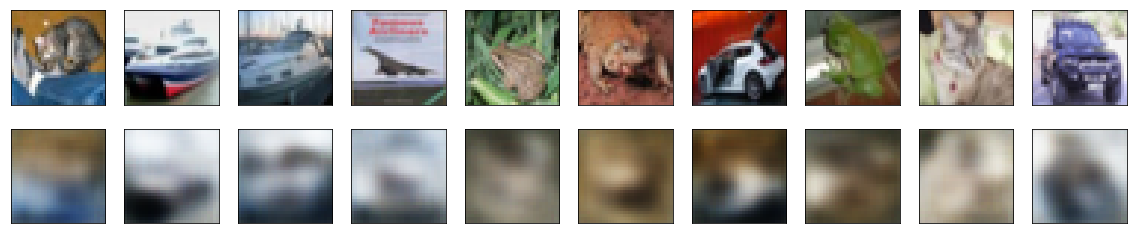

In [10]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## First weights layer

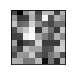

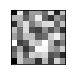

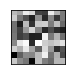

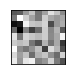

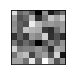

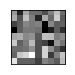

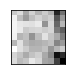

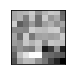

In [11]:
import matplotlib.pyplot as plt
import numpy as np

n = 8

for i in range(n):
    fig = plt.figure(figsize=(1,1))
    conv_1 = np.asarray(autoencoder.layers[1].get_weights())[0][:,:,0,i]
    ax = fig.add_subplot(111)
    plt.imshow(conv_1, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

In [13]:
from keras import backend as K

# K.learning_phase() is a flag that indicates if the network is in training or
# predict phase. It allow layer (e.g. Dropout) to only be applied during training
inputs = [K.learning_phase()] + autoencoder.inputs

_layer1_f = K.function(inputs, [x2])
def convout1_f(X):
    # The [0] is to disable the training phase flag
    return _layer1_f([0] + [X])

_lay_f = K.function(inputs, [x1])
def convout12_f(X):
    # The [0] is to disable the training phase flag
    return _lay_f([0] + [X])

_layer2_f = K.function(inputs, [x4])
def convout2_f(X):
    # The [0] is to disable the training phase flag
    return _layer2_f([0] + [X])

_layer3_f = K.function(inputs, [encoded])
def convout3_f(X):
    # The [0] is to disable the training phase flag
    return _layer3_f([0] + [X])

_up_layer1_f = K.function(inputs, [x6])
def convout4_f(X):
    # The [0] is to disable the training phase flag
    return _up_layer1_f([0] + [X])

_up_layer2_f = K.function(inputs, [x8])
def convout5_f(X):
    # The [0] is to disable the training phase flag
    return _up_layer2_f([0] + [X])

_up_layer3_f = K.function(inputs, [x10])
def convout6_f(X):
    # The [0] is to disable the training phase flag
    return _up_layer3_f([0] + [X])

_up_layer4_f = K.function(inputs, [decoded])
def convout7_f(X):
    # The [0] is to disable the training phase flag
    return _up_layer4_f([0] + [X])


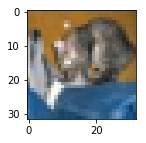

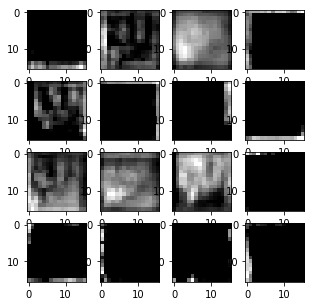

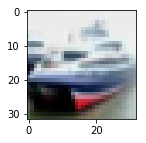

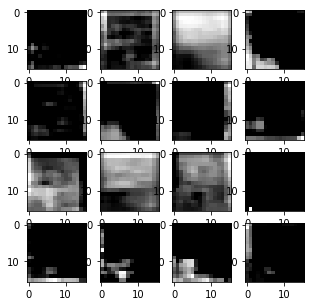

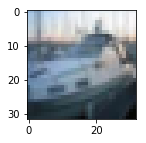

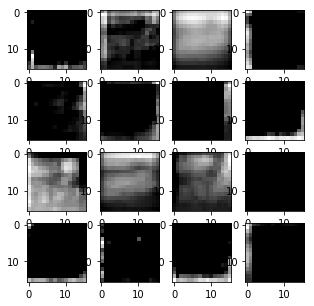

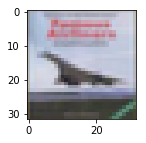

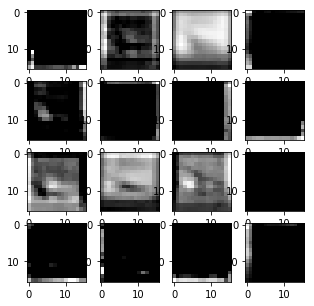

In [21]:
for i in range(4):
    
    #x = x_test[i:i+1]

    #Plotting conv_1
    #i = 1
    x = x_test[i:i+1]
    check = np.squeeze(np.squeeze(np.array(convout1_f(x)),0),0)

    temp = x[0,:,:,:]
    fig, axes = plt.subplots(1, 1, figsize=(2, 2))
    plt.imshow(temp)
    plt.show()


    k = 0
    while k < check.shape[2]:
        #plt.figure()
        #plt.subplot(231 + i)
        fig, axes = plt.subplots(4, 4, figsize=(5, 5))
        for i in range(4):
            for j in range(4):
                axes[i,j].imshow(check[:,:,k], cmap = 'gray')
                k += 1
        #axes[0, 0].imshow(R, cmap='jet')
        #plt.imshow(check[:,:,i])

    plt.show()

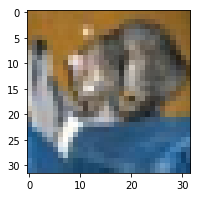

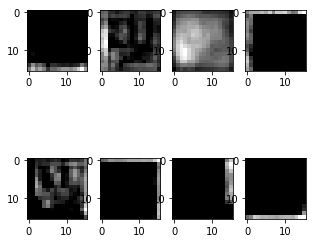

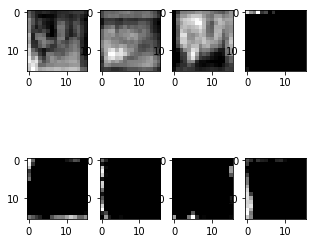

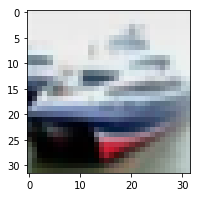

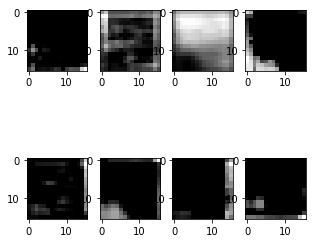

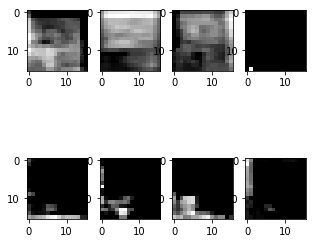

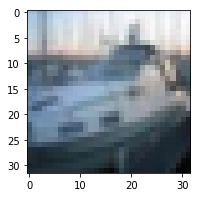

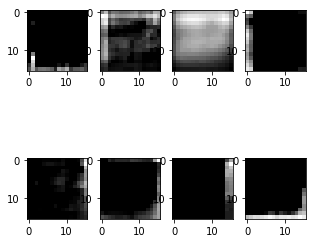

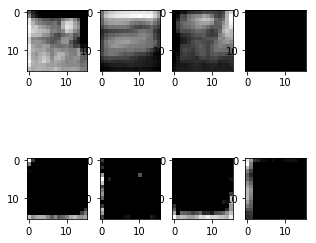

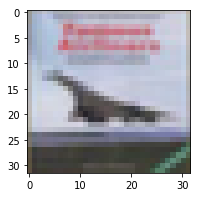

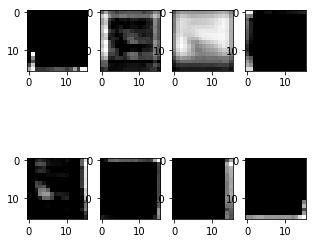

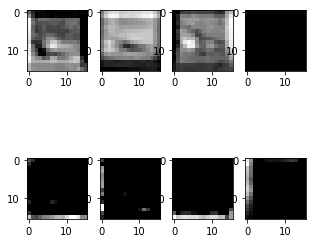

In [22]:
#Plotting conv 2

for i in range(4):
    x = x_test[i:i+1]
    check = np.squeeze(np.squeeze(np.array(convout1_f(x)),0),0)

    temp = x[0,:,:,:]
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))
    plt.imshow(temp)
    plt.show()


    k = 0
    while k < check.shape[2]:
        #plt.figure()
        #plt.subplot(231 + i)
        fig, axes = plt.subplots(2, 4, figsize=(5, 5))
        for i in range(2):
            for j in range(4):
                axes[i,j].imshow(check[:,:,k])
                k += 1
        #axes[0, 0].imshow(R, cmap='jet')
        #plt.imshow(check[:,:,i])

    plt.show()

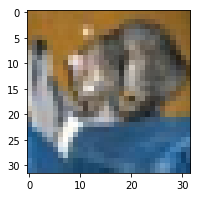

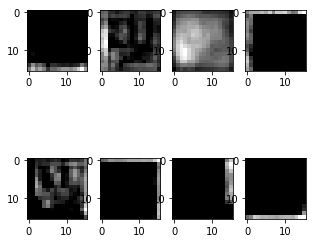

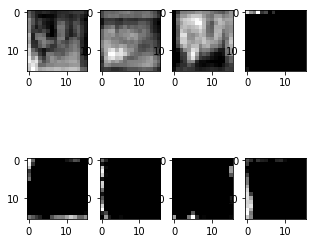

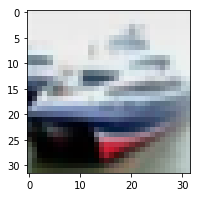

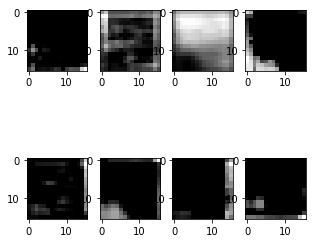

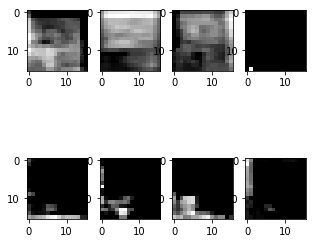

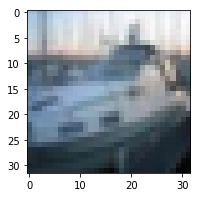

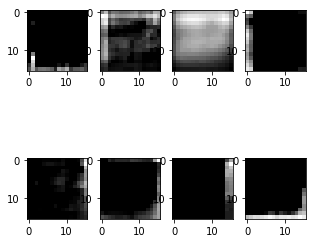

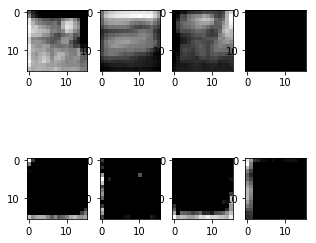

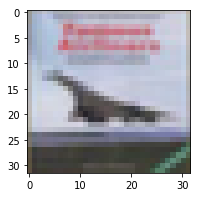

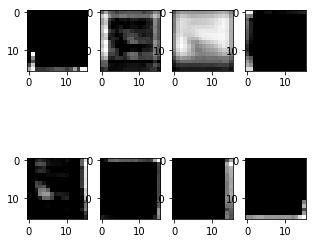

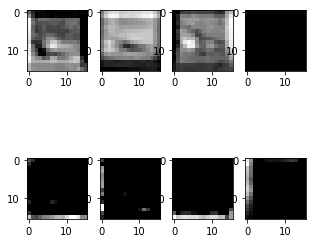

In [24]:
#Plotting conv 3

for i in range(4):
    x = x_test[i:i+1]
    check = np.squeeze(np.squeeze(np.array(convout1_f(x)),0),0)

    temp = x[0,:,:,:]
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))
    plt.imshow(temp)
    plt.show()



    k = 0
    while k < check.shape[2]:
        #plt.figure()
        #plt.subplot(231 + i)
        fig, axes = plt.subplots(2, 4, figsize=(5, 5))
        for i in range(2):
            for j in range(4):
                axes[i,j].imshow(check[:,:,k])
                k += 1
        #axes[0, 0].imshow(R, cmap='jet')
        #plt.imshow(check[:,:,i])


        plt.show()

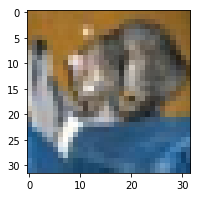

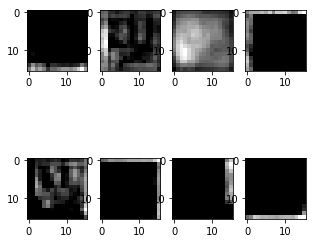

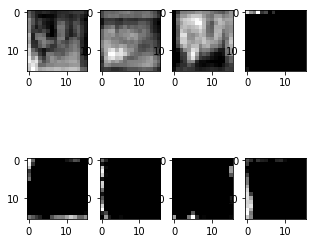

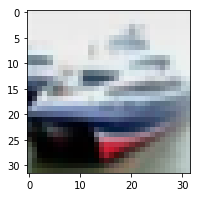

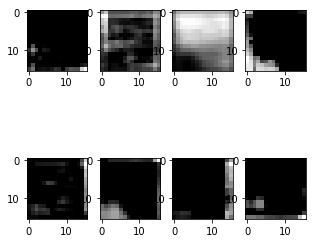

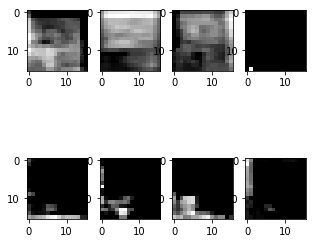

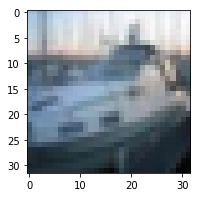

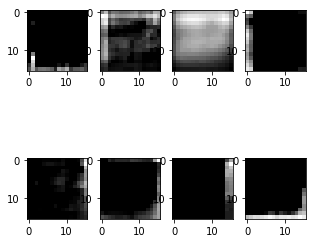

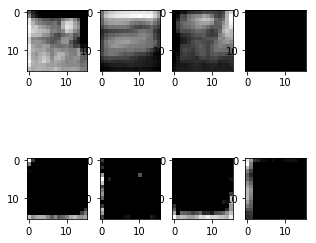

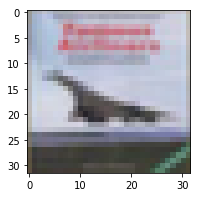

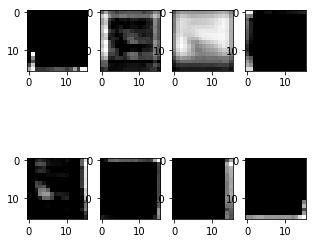

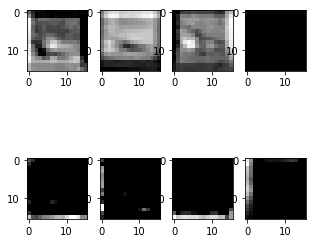

In [26]:
#Plotting conv_4

for i in range(4):
    x = x_test[i:i+1]
    check = np.squeeze(np.squeeze(np.array(convout1_f(x)),0),0)

    temp = x[0,:,:,:]
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))
    plt.imshow(temp)
    plt.show()

    k = 0
    while k < check.shape[2]:
        #plt.figure()
        #plt.subplot(231 + i)
        fig, axes = plt.subplots(2, 4, figsize=(5, 5))
        for i in range(2):
            for j in range(4):
                axes[i,j].imshow(check[:,:,k])
                k += 1
        #axes[0, 0].imshow(R, cmap='jet')
        #plt.imshow(check[:,:,i])

        plt.show()

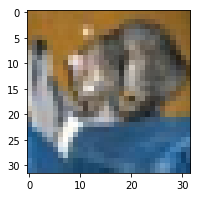

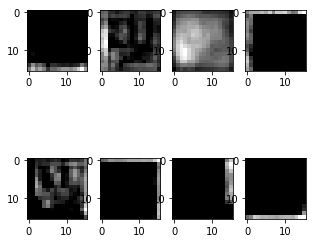

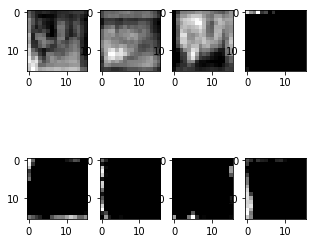

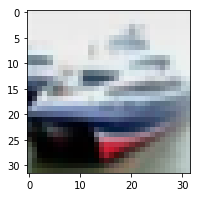

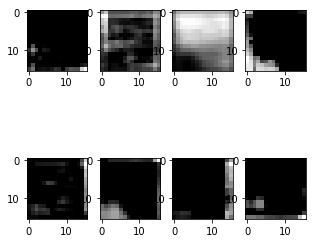

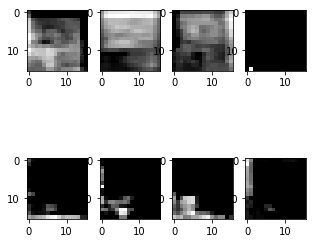

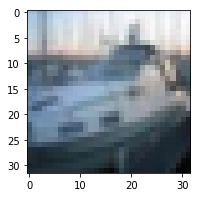

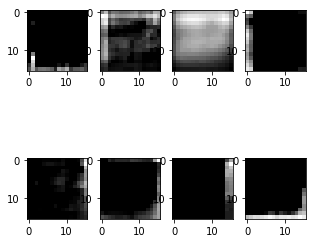

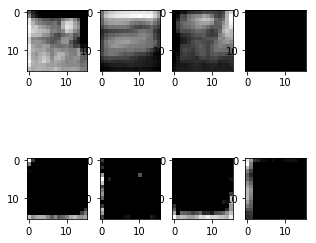

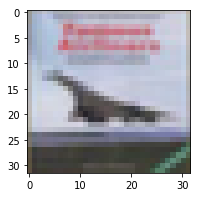

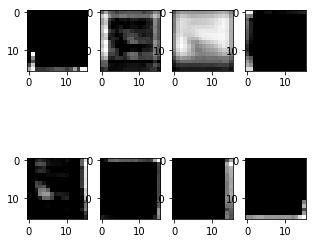

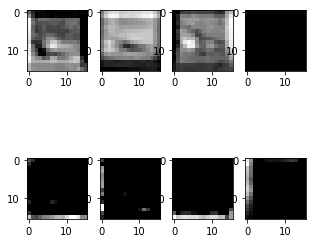

In [27]:
#Plotting conv_4

for i in range(4):
    x = x_test[i:i+1]
    check = np.squeeze(np.squeeze(np.array(convout1_f(x)),0),0)
    
    temp = x[0,:,:,:]
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))
    plt.imshow(temp)
    plt.show()

    k = 0
    while k < check.shape[2]:
        #plt.figure()
        #plt.subplot(231 + i)
        fig, axes = plt.subplots(2, 4, figsize=(5, 5))
        for i in range(2):
            for j in range(4):
                axes[i,j].imshow(check[:,:,k])
                k += 1
        #axes[0, 0].imshow(R, cmap='jet')
        #plt.imshow(check[:,:,i])

    plt.show()

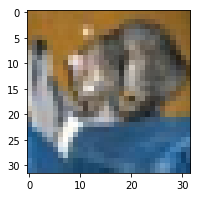

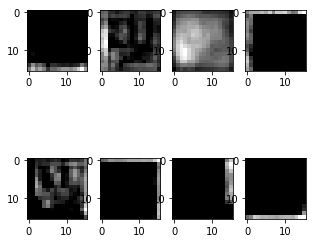

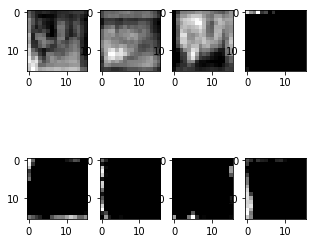

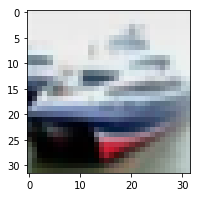

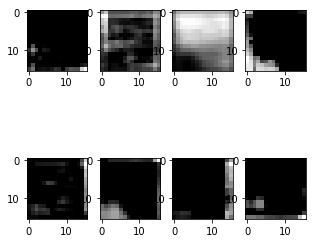

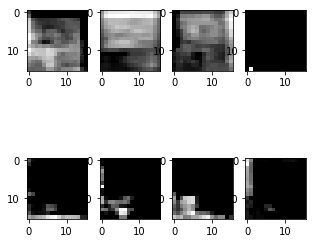

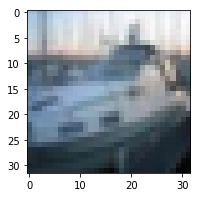

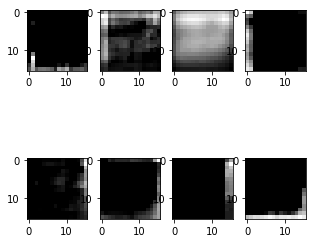

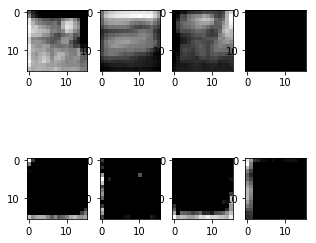

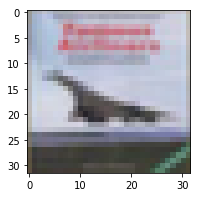

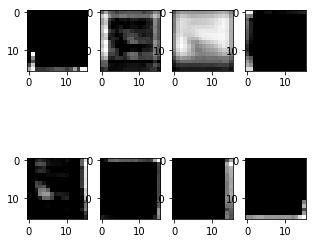

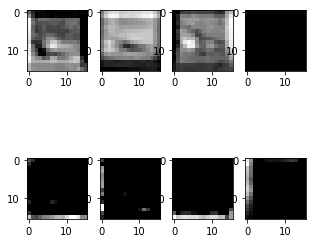

In [35]:
#Plotting conv_5

for z in range(4):
    x = x_test[z:z+1]
    check = np.squeeze(np.squeeze(np.array(convout1_f(x)),0),0)
    
    temp = x[0,:,:,:]
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))
    plt.imshow(temp)
    plt.show()

    k = 0
    while k < check.shape[2]:
        #plt.figure()
        #plt.subplot(231 + i)
        fig, axes = plt.subplots(2, 4, figsize=(5, 5))
        for i in range(2):
            for j in range(4):
                axes[i,j].imshow(check[:,:,k])
                k += 1
        #axes[0, 0].imshow(R, cmap='jet')
        #plt.imshow(check[:,:,i])

    plt.show()

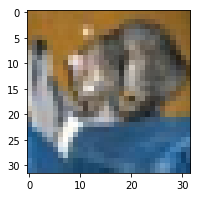

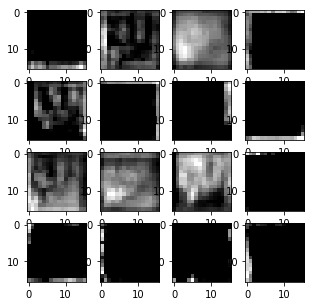

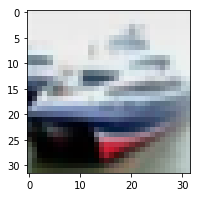

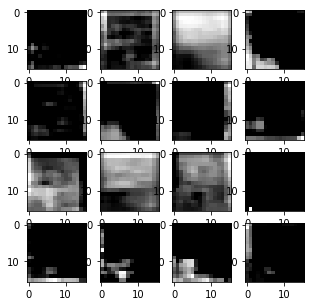

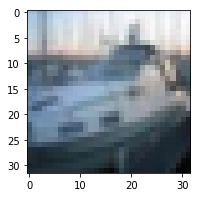

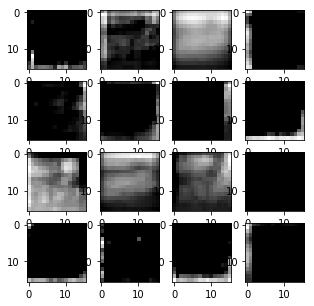

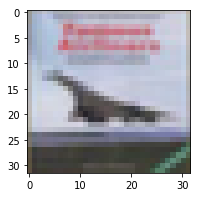

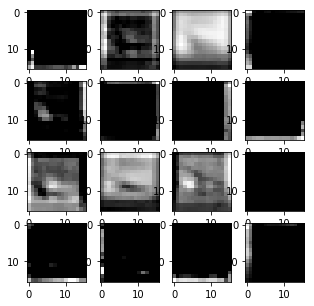

In [36]:
#Plotting conv_6
for z in range(4):
    x = x_test[z:z+1]
    check = np.squeeze(np.squeeze(np.array(convout1_f(x)),0),0)
    
    temp = x[0,:,:,:]
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))
    plt.imshow(temp)
    plt.show()


    k = 0
    while k < check.shape[2]:
        #plt.figure()
        #plt.subplot(231 + i)
        fig, axes = plt.subplots(4, 4, figsize=(5, 5))
        for i in range(4):
            for j in range(4):
                axes[i,j].imshow(check[:,:,k])
                k += 1
        #axes[0, 0].imshow(R, cmap='jet')
        #plt.imshow(check[:,:,i])

    plt.show()

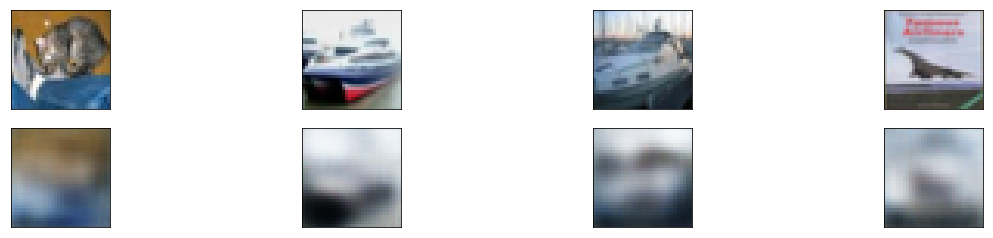

In [39]:
#Final decoded images

decoded_imgs = autoencoder.predict(x_test)

n = 4
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()